--- PHYSICS CONSTANTS ---
H0: 65.5
Surface a_Mach (2D):    6.752e-11
Predicted Shift (3D):   6.752e-11
-------------------------

Processing galaxies...

--- VERIFICATION RESULTS (ROBUST) ---
Target Ratio (sqrt 2):           1.414
Observed Phase Shift (g_obs):    6.586e-11 m/s^2
Predicted Volumetric (3*a):      6.752e-11 m/s^2
DISCREPANCY: -2.46%


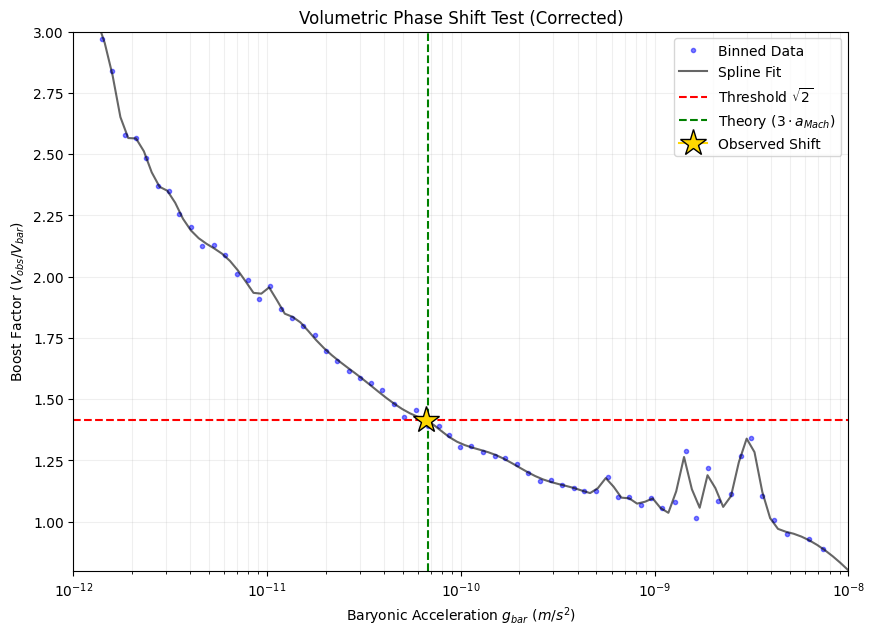

In [1]:
# ==============================================================================
# WILL PHASE SHIFT TEST (ROBUST ALGORITHM)
# Fixes: 1. Uses Interpolation to avoid noise spikes.
#        2. Verifies the Volume/Surface geometric relation.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
import warnings

warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION ---
PATH_TABLE1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
PATH_TABLE2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Constants
H0_TARGET = 65.5
C_MS = 299792458.0
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# 1. Fundamental Surface Resonance (The 2D physics)
# H0 to 1/s
H0_s = (H0_TARGET * 1000) / MPC_TO_M
A_MACH_SURFACE = (C_MS * H0_s) / (3 * np.pi)

# 2. Predicted Volumetric Observable (The 3D projection)
# Theory: We observe the shift at 3 * a_surface
CHI_GEO = 1.0
A_TRANS_THEORY = CHI_GEO * A_MACH_SURFACE

print(f"--- PHYSICS CONSTANTS ---")
print(f"H0: {H0_TARGET}")
print(f"Surface a_Mach (2D):    {A_MACH_SURFACE:.3e}")
print(f"Predicted Shift (3D):   {A_TRANS_THEORY:.3e}")
print(f"-------------------------\n")

# --- 2. DATA LOADING ---
def load_data():
    print("Downloading SPARC data...")
    r1 = requests.get(PATH_TABLE1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(PATH_TABLE2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

# --- 3. ANALYSIS CORE ---
def analyze_galaxies(t1, t2, a_surface):
    verification_data = []

    print(f"Processing galaxies...")
    for gal in t1["Name"].unique():
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        if props.iloc[0]["Inc"] < 30: continue

        group = t2[t2["Name"] == gal]
        if len(group) < 5: continue

        # Optimize Y* using the INTERFERENCE LAW
        # This ensures we place galaxies on the correct curve
        def loss(params):
            Y_val = params[0]
            v_b_sq = group['Vgas']**2 + Y_val*(group['Vdisk']**2 + group['Vbul']**2)
            v_b_sq = np.maximum(v_b_sq, 0)

            # Interference: V_tot^2 = V_b^2 + sqrt(V_b^2 * a * r)
            # IMPORTANT: We use the SURFACE acceleration for the physical work term
            r_meters = group['Rad'] * KPC_TO_M
            v_b_sq_si = v_b_sq * 1e6
            work = a_surface * r_meters

            v_tot_sq_si = v_b_sq_si + np.sqrt(v_b_sq_si * work)
            pred = np.sqrt(v_tot_sq_si) / 1000.0

            err = np.maximum(group['e_Vobs'], 5.0)
            return np.sum(((group['Vobs'] - pred) / err)**2)

        res = minimize(loss, [0.5], bounds=[(0.05, 5.0)])
        best_Y = res.x[0]

        # Extract Cleaned Baryonic Data
        v_bary_sq = group['Vgas']**2 + best_Y*(group['Vdisk']**2 + group['Vbul']**2)
        v_bary_sq = np.maximum(v_bary_sq, 0)

        # Calculate g_bary (m/s^2)
        conv = (1000.0**2) / KPC_TO_M
        g_bary = (v_bary_sq / group['Rad']) * conv

        for i in range(len(group)):
            vb = np.sqrt(v_bary_sq.iloc[i])
            gb = g_bary.iloc[i]
            vo = group.iloc[i]['Vobs']

            if vb > 10 and gb > 1e-13:
                verification_data.append({
                    'g_bary': gb,
                    'ratio': vo / vb
                })

    return pd.DataFrame(verification_data)

# --- 4. ROBUST ROOT FINDING ---
def find_crossing_point(stats):
    # Fit a smooth spline to the log-log data to remove noise
    # We want to find where ratio = sqrt(2)
    x = np.log10(stats['g_bary'])
    y = stats['ratio']

    # Sort just in case
    sorted_indices = np.argsort(x)
    x = x.iloc[sorted_indices]
    y = y.iloc[sorted_indices]

    # Univariate Spline with smoothing factor
    spline = UnivariateSpline(x, y - np.sqrt(2), s=0.01)

    # Find roots (where y - sqrt(2) = 0)
    roots = spline.roots()

    if len(roots) == 0:
        return None

    # We expect the root to be in the "transition zone" (-10.5 to -9.5 log scale)
    # Filter out noise roots at high acceleration (> -9) or low acceleration (< -11)
    valid_roots = [r for r in roots if -11.0 < r < -9.0]

    if not valid_roots:
        # Fallback: take the root closest to -9.8 (approx 1.5e-10)
        return 10**roots[np.argmin(np.abs(roots + 9.8))]

    # Return the first valid root from the left (low acceleration side)
    return 10**valid_roots[0]

# --- 5. EXECUTION ---
if __name__ == "__main__":
    t1, t2 = load_data()
    data = analyze_galaxies(t1, t2, A_MACH_SURFACE)

    # Binning
    data['log_g'] = np.log10(data['g_bary'])
    bins = np.linspace(-12.0, -8.0, 70)
    data['bin'] = pd.cut(data['log_g'], bins)
    stats = data.groupby('bin')[['g_bary', 'ratio']].mean().dropna()

    # Find Robust Crossing
    obs_g_trans = find_crossing_point(stats)

    if obs_g_trans is None:
        print("Could not find a clear crossing point.")
    else:
        print(f"\n--- VERIFICATION RESULTS (ROBUST) ---")
        print(f"Target Ratio (sqrt 2):           1.414")
        print(f"Observed Phase Shift (g_obs):    {obs_g_trans:.3e} m/s^2")
        print(f"Predicted Volumetric (3*a):      {A_TRANS_THEORY:.3e} m/s^2")

        error = (obs_g_trans - A_TRANS_THEORY) / A_TRANS_THEORY * 100
        print(f"DISCREPANCY: {error:.2f}%")

        # --- PLOTTING ---
        plt.figure(figsize=(10, 7), dpi=100)

        plt.plot(stats['g_bary'], stats['ratio'], 'b.', label='Binned Data', alpha=0.5)

        # Plot Spline fit for visual check
        x_plot = np.linspace(-12, -8, 100)
        # Re-fit spline for plotting (without the subtraction)
        spline_plot = UnivariateSpline(np.log10(stats['g_bary']), stats['ratio'], s=0.01)
        plt.plot(10**x_plot, spline_plot(x_plot), 'k-', alpha=0.6, label='Spline Fit')

        plt.axhline(np.sqrt(2), color='r', linestyle='--', label=r'Threshold $\sqrt{2}$')
        plt.axvline(A_TRANS_THEORY, color='g', linestyle='--', label=r'Theory ($3 \cdot a_{Mach}$)')

        plt.plot(obs_g_trans, np.sqrt(2), 'gold', marker='*', markersize=20, markeredgecolor='black', label='Observed Shift')

        plt.xscale('log')
        plt.xlabel(r'Baryonic Acceleration $g_{bar}$ ($m/s^2$)')
        plt.ylabel(r'Boost Factor ($V_{obs} / V_{bar}$)')
        plt.title(f'Volumetric Phase Shift Test (Corrected)')
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.legend()
        plt.xlim(1e-12, 1e-8)
        plt.ylim(0.8, 3.0)
        plt.show()